In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random as pyrandom
from numpy import random
import seaborn as sb
from sklearn import svm
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from random import choice
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
from pylab import *  
from matplotlib.ticker import MultipleLocator, FormatStrFormatter  
from collections import Counter
from sklearn.calibration import CalibratedClassifierCV

In [44]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_data=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/train_data.npy")
train_label=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/train_label.npy")
test_data=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/test_data.npy")
test_label=np.load("D:/GitHub/Neural-Network-Theory-and-Applications-Homework-SJTU2018/Homework Assignment 2/data_hw2/test_label.npy")

##原来的标签是{-1,0,1}，现在变为三堆样本标签，正样本是0，负样本是1

In [4]:
train_label_0=np.where(train_label == 0, 0, 1)
train_label_1=np.where(train_label == 1, 0, 1)
train_label_negative1=np.where(train_label == -1, 0, 1)

test_label_0=np.where(test_label == 0, 0, 1)
test_label_1=np.where(test_label == 1, 0, 1)
test_label_negative1=np.where(test_label == -1, 0, 1)

##将三个二分类问题的索引随机打乱,二分类问题随机分为8组，共24组

In [5]:
range_0=np.arange(37360)
np.random.shuffle(range_0)
range_1=np.arange(37360)
np.random.shuffle(range_1)
range_negative1=np.arange(37360)
np.random.shuffle(range_negative1)

现在的目的是，将打乱的range_x分成8组,

In [6]:
index_0=range_0.reshape(8,4670)
index_1=range_1.reshape(8,4670)
index_negative1=range_negative1.reshape(8,4670)

##为每个二分类问题建立8个分类器，一共24个SVM分类器

In [29]:
svc_0_0=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_1=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_2=CalibratedClassifierCV(svm.LinearSVC(C=2e-7))
svc_0_3=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_4=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_5=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_6=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_0_7=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 

svc_1_0=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_1=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_2=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_3=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_4=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_5=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_6=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 
svc_1_7=CalibratedClassifierCV(svm.LinearSVC(C=2e-7)) 

svc_negative1_0=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_1=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_2=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_3=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_4=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_5=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_6=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 
svc_negative1_7=CalibratedClassifierCV(svm.LinearSVC(C=1e-5)) 

##每个二分类问题训练8个分类器，一共训练24个分类器

In [30]:
svc_0_0.fit(train_data[index_0[0,:]], train_label_0[index_0[0,:]])
svc_0_1.fit(train_data[index_0[1,:]], train_label_0[index_0[1,:]])
svc_0_2.fit(train_data[index_0[2,:]], train_label_0[index_0[2,:]])
svc_0_3.fit(train_data[index_0[3,:]], train_label_0[index_0[3,:]])
svc_0_4.fit(train_data[index_0[4,:]], train_label_0[index_0[4,:]])
svc_0_5.fit(train_data[index_0[5,:]], train_label_0[index_0[5,:]])
svc_0_6.fit(train_data[index_0[6,:]], train_label_0[index_0[6,:]])
svc_0_7.fit(train_data[index_0[7,:]], train_label_0[index_0[7,:]])

CalibratedClassifierCV(base_estimator=LinearSVC(C=2e-07, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [31]:
svc_1_0.fit(train_data[index_1[0,:]], train_label_1[index_1[0,:]])
svc_1_1.fit(train_data[index_1[1,:]], train_label_1[index_1[1,:]])
svc_1_2.fit(train_data[index_1[2,:]], train_label_1[index_1[2,:]])
svc_1_3.fit(train_data[index_1[3,:]], train_label_1[index_1[3,:]])
svc_1_4.fit(train_data[index_1[4,:]], train_label_1[index_1[4,:]])
svc_1_5.fit(train_data[index_1[5,:]], train_label_1[index_1[5,:]])
svc_1_6.fit(train_data[index_1[6,:]], train_label_1[index_1[6,:]])
svc_1_7.fit(train_data[index_1[7,:]], train_label_1[index_1[7,:]])

CalibratedClassifierCV(base_estimator=LinearSVC(C=2e-07, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [32]:
svc_negative1_0.fit(train_data[index_negative1[0,:]], train_label_negative1[index_negative1[0,:]])
svc_negative1_1.fit(train_data[index_negative1[1,:]], train_label_negative1[index_negative1[1,:]])
svc_negative1_2.fit(train_data[index_negative1[2,:]], train_label_negative1[index_negative1[2,:]])
svc_negative1_3.fit(train_data[index_negative1[3,:]], train_label_negative1[index_negative1[3,:]])
svc_negative1_4.fit(train_data[index_negative1[4,:]], train_label_negative1[index_negative1[4,:]])
svc_negative1_5.fit(train_data[index_negative1[5,:]], train_label_negative1[index_negative1[5,:]])
svc_negative1_6.fit(train_data[index_negative1[6,:]], train_label_negative1[index_negative1[6,:]])
svc_negative1_7.fit(train_data[index_negative1[7,:]], train_label_negative1[index_negative1[7,:]])

CalibratedClassifierCV(base_estimator=LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

##实现min-max-modular

In [33]:
test_pred_0_0 = svc_0_0.predict_proba(test_data)[:,0]
test_pred_0_1 = svc_0_1.predict_proba(test_data)[:,0]
test_pred_0_2 = svc_0_2.predict_proba(test_data)[:,0]
test_pred_0_3 = svc_0_3.predict_proba(test_data)[:,0]
test_pred_0_4 = svc_0_4.predict_proba(test_data)[:,0]
test_pred_0_5 = svc_0_5.predict_proba(test_data)[:,0]
test_pred_0_6 = svc_0_6.predict_proba(test_data)[:,0]
test_pred_0_7 = svc_0_7.predict_proba(test_data)[:,0]

test_pred_1_0 = svc_1_0.predict_proba(test_data)[:,0]
test_pred_1_1 = svc_1_1.predict_proba(test_data)[:,0]
test_pred_1_2 = svc_1_2.predict_proba(test_data)[:,0]
test_pred_1_3 = svc_1_3.predict_proba(test_data)[:,0]
test_pred_1_4 = svc_1_4.predict_proba(test_data)[:,0]
test_pred_1_5 = svc_1_5.predict_proba(test_data)[:,0]
test_pred_1_6 = svc_1_6.predict_proba(test_data)[:,0]
test_pred_1_7 = svc_1_7.predict_proba(test_data)[:,0]

test_pred_negative1_0 = svc_negative1_0.predict_proba(test_data)[:,0]
test_pred_negative1_1 = svc_negative1_1.predict_proba(test_data)[:,0]
test_pred_negative1_2 = svc_negative1_2.predict_proba(test_data)[:,0]
test_pred_negative1_3 = svc_negative1_3.predict_proba(test_data)[:,0]
test_pred_negative1_4 = svc_negative1_4.predict_proba(test_data)[:,0]
test_pred_negative1_5 = svc_negative1_5.predict_proba(test_data)[:,0]
test_pred_negative1_6 = svc_negative1_6.predict_proba(test_data)[:,0]
test_pred_negative1_7 = svc_negative1_7.predict_proba(test_data)[:,0]

In [34]:
test_pred_0_1x=np.vstack([test_pred_0_0,test_pred_0_1,test_pred_0_2,test_pred_0_3]) #test_pred_0_1x.shape=(4, 13588)
test_pred_0_2x=np.vstack([test_pred_0_4,test_pred_0_5,test_pred_0_6,test_pred_0_7])
test_pred_1_1x=np.vstack([test_pred_1_0,test_pred_1_1,test_pred_1_2,test_pred_1_3])
test_pred_1_2x=np.vstack([test_pred_1_4,test_pred_1_5,test_pred_1_6,test_pred_1_7])
test_pred_negative1_1x=np.vstack([test_pred_negative1_0,test_pred_negative1_1,test_pred_negative1_2,test_pred_negative1_3])
test_pred_negative1_2x=np.vstack([test_pred_negative1_4,test_pred_negative1_5,test_pred_negative1_6,test_pred_negative1_7])

In [35]:
test_pred_0=[]
test_pred_1=[]
test_pred_negative1=[]
for i in range(13588):
    min_index_0_1x=int(np.where(test_pred_0_1x[:,i]==np.min(test_pred_0_1x[:,i]))[0])
    min_index_0_2x=int(np.where(test_pred_0_2x[:,i]==np.min(test_pred_0_2x[:,i]))[0])
    if test_pred_0_1x[min_index_0_1x,i] > test_pred_0_2x[min_index_0_2x,i]:
        test_pred_0.append(test_pred_0_1x[min_index_0_1x,i])
    else:
        test_pred_0.append(test_pred_0_2x[min_index_0_2x,i])
        
for i in range(13588):
    min_index_1_1x=int(np.where(test_pred_1_1x[:,i]==np.min(test_pred_1_1x[:,i]))[0])
    min_index_1_2x=int(np.where(test_pred_1_2x[:,i]==np.min(test_pred_1_2x[:,i]))[0])
    if test_pred_1_1x[min_index_1_1x,i] > test_pred_1_2x[min_index_1_2x,i]:
        test_pred_1.append(test_pred_1_1x[min_index_1_1x,i])
    else:
        test_pred_1.append(test_pred_1_2x[min_index_1_2x,i])
        
for i in range(13588):
    min_index_negative1_1x=int(np.where(test_pred_negative1_1x[:,i]==np.min(test_pred_negative1_1x[:,i]))[0])
    min_index_negative1_2x=int(np.where(test_pred_negative1_2x[:,i]==np.min(test_pred_negative1_2x[:,i]))[0])
    if test_pred_negative1_1x[min_index_negative1_1x,i] > test_pred_negative1_2x[min_index_negative1_2x,i]:
        test_pred_negative1.append(test_pred_negative1_1x[min_index_negative1_1x,i])
    else:
        test_pred_negative1.append(test_pred_negative1_2x[min_index_negative1_2x,i])

In [36]:
test_pred=[]
train_pred=[]
for i in range(13588):
    maxone=max(test_pred_0[i],test_pred_1[i],test_pred_negative1[i])
    if maxone == test_pred_0[i]:
        test_pred.append(0)
    elif maxone == test_pred_1[i]:
        test_pred.append(1)
    elif maxone == test_pred_negative1[i]:
        test_pred.append(-1)

In [37]:
test_label_roc=np.concatenate((test_label_0,test_label_1,test_label_negative1)) 
test_pred_roc=np.concatenate((test_pred_0,test_pred_1,test_pred_negative1))

In [48]:
#画ROC曲线和计算AUC  
fpr_0, tpr_0, thresholds_0 = roc_curve(test_label_0, test_pred_0,pos_label=0)#
roc_auc_0 = auc(fpr_0, tpr_0)    
fpr_1, tpr_1, thresholds_1 = roc_curve(test_label_1, test_pred_1,pos_label=0)#
roc_auc_1 = auc(fpr_1, tpr_1)  
fpr_negative1, tpr_negative1, thresholds_negative1 = roc_curve(test_label_negative1, test_pred_negative1,pos_label=0)#
roc_auc_negative1 = auc(fpr_negative1, tpr_negative1) 
fpr_m_ran, tpr_m_ran, thresholds_m_ran = roc_curve(test_label_roc, test_pred_roc,pos_label=0)
roc_auc_m = auc(fpr_m_ran, tpr_m_ran)

In [51]:
%store fpr_m_ran
%store tpr_m_ran

Stored 'fpr_m_ran' (ndarray)
Stored 'tpr_m_ran' (ndarray)


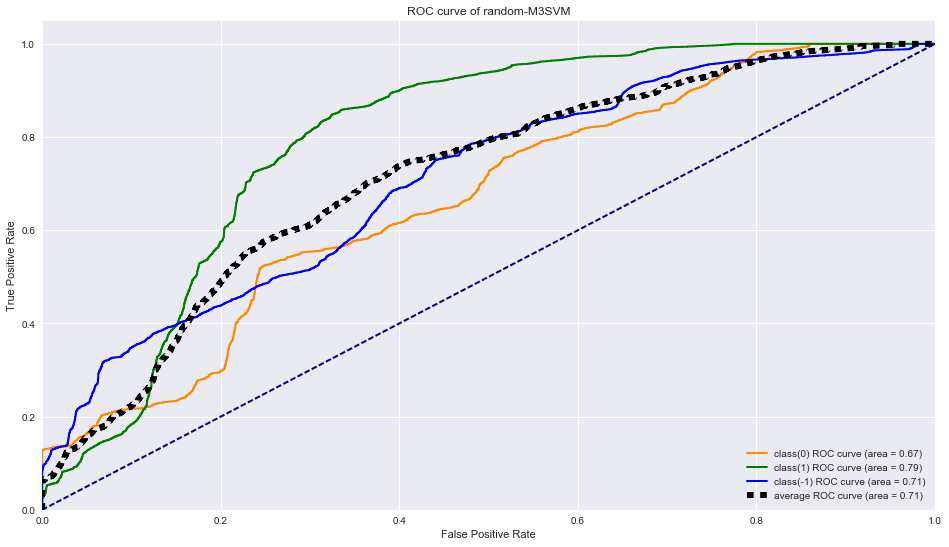

In [49]:
plt.figure()
lw = 2
plt.plot(fpr_0, tpr_0, color='darkorange',
         lw=lw, label='class(0) ROC curve (area = %0.2f)' % roc_auc_0)
plt.plot(fpr_1, tpr_1, color='green',
         lw=lw, label='class(1) ROC curve (area = %0.2f)' % roc_auc_1)
plt.plot(fpr_negative1, tpr_negative1, color='blue',
         lw=lw, label='class(-1) ROC curve (area = %0.2f)' % roc_auc_negative1)
plt.plot(fpr_m_ran, tpr_m_ran, color='black',linestyle=':',
         lw=6, label='average ROC curve (area = %0.2f)' % roc_auc_m)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of random-M3SVM')
plt.legend(loc="lower right")
plt.savefig('roc random-m3svm.png')
sb.plt.show()

In [40]:
print(accuracy_score(test_label, test_pred))

0.580659405358


In [41]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test_label, test_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.54      0.44      0.48      4480
    class 1       0.54      0.45      0.49      4416
    class 2       0.63      0.84      0.72      4692

avg / total       0.57      0.58      0.57     13588

